In [1]:
"""
Machine Learning Final Project Trading Strategy
Author: Jiaxin Zhang, Jiaxun Song
"""

import pandas as pd
from pandas_datareader import data
import numpy as np
from random import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#Load in data sets
#Get stock data from Yahoo Finance

def load_data(start_date, end_date):
    df_United = data.DataReader('UAL', 'yahoo', start=start_date,end=end_date)
    #include other parameters that could predict the movement of united
    df_oil_index = data.DataReader('VDE', 'yahoo', start=start_date,end=end_date)
    df_airline_index = data.DataReader('^XAL', 'yahoo', start=start_date,end=end_date)
    df_SP500 = data.DataReader('^GSPC', 'yahoo', start=start_date,end=end_date)
    df_Dow = data.DataReader('^DJI', 'yahoo', start=start_date,end=end_date)
    df_Delta = data.DataReader('DAL', 'yahoo', start=start_date,end=end_date)
    df_jetblue = data.DataReader('JBLU', 'yahoo', start=start_date,end=end_date)
    df_Boeing = data.DataReader('BA', 'yahoo', start=start_date,end=end_date)
    df_airbus = data.DataReader('AIR.PA', 'yahoo', start=start_date,end=end_date)
   
    
    df_United['airline_index'] = df_airline_index['Adj Close']
    df_United['oil_index'] = df_oil_index['Adj Close']
    df_United['SP500'] = df_SP500['Adj Close']
    df_United['Dow'] = df_Dow['Adj Close']
    df_United['Delta'] = df_Delta['Adj Close']
    df_United['Boeing'] = df_Boeing['Adj Close']
    df_United['Airbus'] = df_airbus['Adj Close']
    df_United['Jetblue'] = df_jetblue['Adj Close']
    
    return df_United 
#Train data: from 2005-01-01 to 2015-12-31
#Test data: from 2016-01-01 to 2019-10-31
data_train = load_data('2005-01-01','2015-12-31').dropna()
data_test = load_data('2016-01-01','2019-10-31').dropna()
data_train.head()

,High,Low,Open,Close,Volume,Adj Close,airline_index,oil_index,SP500,Dow,Delta,Boeing,Airbus,Jetblue
Date,,,,,,,,,,,,,,
2007-05-03,35.000000,33.290001,33.950001,33.549999,3700200.0,31.374056,50.520000,72.887444,1502.390015,13241.379883,18.532635,67.927940,18.671965,10.27
2007-05-04,35.759998,33.799999,33.900002,35.570000,4449500.0,33.263046,51.369999,72.833733,1505.619995,13264.620117,18.765188,67.754204,18.768751,10.36
2007-05-07,36.700001,35.080002,36.700001,35.470001,3722000.0,33.169533,51.389999,72.925835,1509.479980,13312.969727,18.210649,68.441826,18.978460,10.47
2007-05-08,36.470001,35.000000,35.029999,35.779999,2182900.0,33.459427,51.310001,72.864410,1507.719971,13309.070312,17.557705,68.188484,18.825209,10.45
2007-05-09,36.180000,35.070000,35.740002,35.250000,3354200.0,32.963802,51.500000,72.964218,1512.579956,13362.870117,17.700813,68.348320,18.954260,10.40


In [2]:
#Functions

#naive strategy
#all in to buy stocks at day 1, and sell all stocks at the last day
def naive(test_data,cash):
    stock = int(cash/test_data["Adj Close"].iloc[0])
    profit = stock* test_data["Adj Close"].iloc[-1]
    
    return profit
       
def action(daily_data,cash,stock,model):
    cash = cash
    stock = stock
    #predict the action
    action = model.predict(daily_data)
    
    #Market assumption: only 80% of the time the trading can be successfully exercised
    #Only exercise when rand <=0.8
    rand = random()
    
    #exercie sell or buy actions
    if action == 1 and cash>=float(daily_data["Adj Close"]) and rand <=0.8:
        #is it right to use int here?
        buy_stock = int(cash/float(daily_data["Adj Close"]))
        stock = stock + buy_stock
        cash = cash - buy_stock*float(daily_data["Adj Close"])
        print(action,"buy",stock, cash, "price",float(daily_data["Adj Close"]))
        
    elif action == -1 and stock > 0 and rand <=0.8:
        cash = cash + stock*float(daily_data["Adj Close"])
        stock = 0
        print(action,"sell",stock,cash,"price",float(daily_data["Adj Close"]))

    return cash,stock

def back_tester(test_data,cash,stock,model):
    value_array = []
    
    for i in range(len(test_data)):
        daily_data = test_data.iloc[i:i+1,:]
        if i == 0 :
            stock = int(cash/float(daily_data["Adj Close"]))
            cash = cash - stock*float(daily_data["Adj Close"])
            value = cash + stock*test_data["Adj Close"].iloc[i]
            value_array.append(value)
        else:    
            cash, stock = action(daily_data,cash,stock,model)
            value = cash + stock*test_data["Adj Close"].iloc[i]
            value_array.append(value)
    
    #plot the graph
    plt.plot(value_array)
    plt.show()
    return value

#function that calculates n-day-moving-avearage
def nday_moving_average(n, mv_data):
    mv = []
    Sn = sum(mv_data[0:n])
    Bn = Sn/n
    mv.append(Bn)
    for i in range(n, len(mv_data)):
        Bn = (Bn*n - mv_data[i-n] + mv_data[i])/n
        mv.append(Bn)
    return mv

#calculating the n-day support and resistance
def nday_window(n, window_data):
    window = window_data[0:n]
    upperlimit = []
    lowerlimit = []
    for i in range(n, len(window_data)):
        upper = max(window)
        lower = min(window)
        threshold = (upper - lower) * 0.15
        upperlim = upper - threshold
        lowerlim = lower + threshold
        upperlimit.append(upperlim)
        lowerlimit.append(lowerlim)
        
        #window.pop(0)
        del window[0]
        window.append(window_data[i])
    return upperlimit, lowerlimit

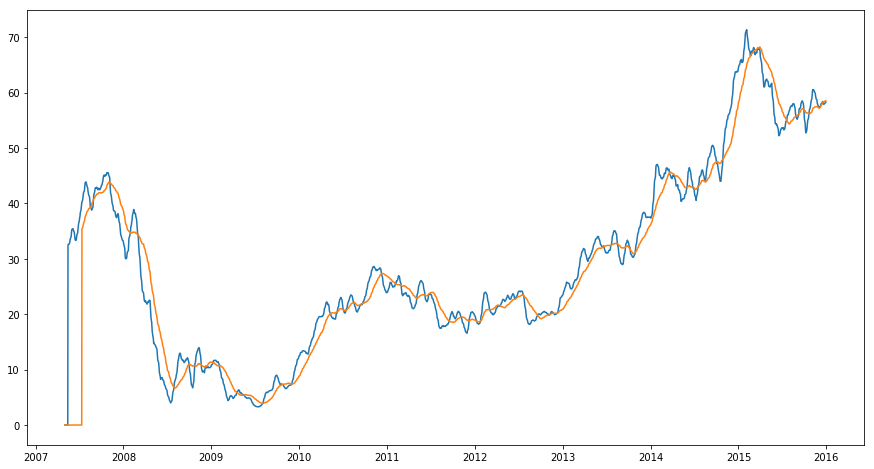

In [4]:
#add 10-day and 50-day moving average to dataframe
mv_data = data_train['Adj Close']
mv10 = nday_moving_average(10, mv_data)
mv50 = nday_moving_average(50, mv_data)
data_train["MA_10"] = 0
data_train["MA_50"] = 0
data_train.iloc[9:len(mv_data),-2] = mv10
data_train.iloc[49:len(mv_data),-1] = mv50

label = [0 for x in range(len(data_train))]

#plot 10-day and 50-day moving avg
plt.figure(figsize=(15,8))
plt.plot(data_train.loc[:,['MA_10','MA_50',]])
plt.show()

In [ ]:
data_train.head()

In [ ]:
#use moving avg to lable the data
"""
label = [0 for x in range(len(data_train))]
for i in range(50,len(data_train)):
    #when MA_10 intersect with MA_50 from below, buy the stock
    if (data_train["MA_10"][i-1] < data_train["MA_50"][i-1]) and (data_train["MA_10"][i] >= data_train["MA_50"][i]):
        label[i] = 1
    #when MA_10 intersect with MA_50 from above, sell the stock
    elif (data_train["MA_10"][i-1] > data_train["MA_50"][i-1]) and (data_train["MA_10"][i] <= data_train["MA_50"][i]):
        label[i] = -1
data_train['class'] = label  
"""

In [4]:
#use the trend to label the data
# using this way to label is the best

for i in range(50,len(data_train)):
    if (data_train["Adj Close"][i] < data_train["MA_10"][i]):
        label[i] = -1
    else:
        label[i] = 1
data_train['class'] = label


In [12]:
#add 10-day and 50-day MV to test data
mv_data_test = data_test['Adj Close']
mv10_test = nday_moving_average(10, mv_data_test)
mv50_test = nday_moving_average(50, mv_data_test)
data_test["MA_10"] = 0
data_test["MA_50"] = 0
data_test.iloc[9:len(data_test),-2] = mv10_test
data_test.iloc[49:len(data_test),-1] = mv50_test


In [ ]:
#drop rows with 0
#data_train = data_train[data_train != 0].dropna()
#data_test = data_test[data_test != 0].dropna()
label = [0 for x in range(len(data_test))]
for i in range(50,len(data_test)):
    if (data_test["Adj Close"][i] < data_test["MA_10"][i]):
        label[i] = -1
    else:
        label[i] = 1
data_test['class'] = label
"""
for i in range(50,len(data_test)):
    #when MA_10 intersect with MA_50 from below, buy the stock
    if (data_test["MA_10"][i-1] < data_test["MA_50"][i-1]) and (data_test["MA_10"][i] >= data_test["MA_50"][i]):
        label[i] = 1
    #when MA_10 intersect with MA_50 from above, sell the stock
    elif (data_test["MA_10"][i-1] > data_test["MA_50"][i-1]) and (data_test["MA_10"][i] <= data_test["MA_50"][i]):
        label[i] = -1
data_test['class'] = label 
"""

In [13]:
#split X and y matrices
X_train = data_train.loc[:,'High':'MA_50']
y_train = data_train['class']
X_test = data_test.loc[:,'High':'MA_50']
#y_test = data_test['class']
#y_test

In [10]:
#the return of naive strategy
naive(data_test,10000)

16405.350273132324

[-1] sell 0 10042.959617614746 price 55.849998474121094
[1] buy 185 40.009674072265625 price 54.06999969482422
[-1] sell 0 9426.909984588623 price 50.7400016784668
[1] buy 211 18.419952392578125 price 44.59000015258789
[-1] sell 0 9523.969791412354 price 45.04999923706055
[1] buy 211 31.079437255859375 price 44.9900016784668
[-1] sell 0 9553.509662628174 price 45.130001068115234
[1] buy 214 30.509662628173828 price 44.5
[-1] sell 0 9696.88927078247 price 45.16999816894531
[1] buy 217 33.87953567504883 price 44.529998779296875
[-1] sell 0 9974.6498336792 price 45.810001373291016
[1] buy 229 36.04948425292969 price 43.400001525878906
[-1] sell 0 10308.989624023438 price 44.86000061035156
[1] buy 228 10.23004150390625 price 45.16999816894531
[-1] sell 0 9371.910354614258 price 41.060001373291016
[1] buy 231 0.24042510986328125 price 40.56999969482422
[-1] sell 0 10988.910354614258 price 47.56999969482422
[1] buy 215 26.059993743896484 price 50.9900016784668
[-1] sell 0 11567.26005935669 p

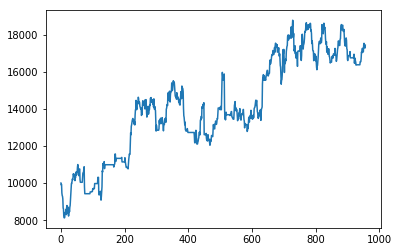

17431.0834274292

In [14]:
#use Random Forest to predict the test-data label and use back_tester to find the result
RFC=RandomForestClassifier(n_estimators=10,random_state = 1)
RFC.fit(X_train,y_train)
back_tester(X_test,10000,0,RFC)
#y_pred = RFC.predict(X_test)
#print("Random forest accurary:",accuracy_score(y_test, y_pred))

[1] buy 180 0.139892578125 price 45.66999816894531


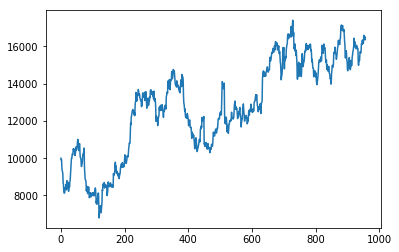

16497.140167236328

In [15]:
#use SVM model
model1 = svm.SVC(kernel='rbf',gamma="auto",random_state = 1)
model1.fit(X_train,y_train)
back_tester(X_test,10000,0,model1)
#y_pred = model1.predict(X_test)
#print("SVM accurary:",accuracy_score(y_test, y_pred))

[-1] sell 0 10198.69010925293 price 56.720001220703125
[1] buy 188 33.53016662597656 price 54.06999969482422
[-1] sell 0 9572.650482177734 price 50.7400016784668
[1] buy 208 44.170196533203125 price 45.810001373291016
[-1] sell 0 9749.450164794922 price 46.65999984741211
[1] buy 214 1.7503280639648438 price 45.54999923706055
[-1] sell 0 10059.750328063965 price 47.0
[1] buy 219 29.550495147705078 price 45.79999923706055
[-1] sell 0 15306.990962982178 price 69.76000213623047
[1] buy 220 3.7915000915527344 price 69.55999755859375
[-1] sell 0 18127.390895843506 price 82.37999725341797
[1] buy 216 35.23043441772461 price 83.76000213623047
[-1] sell 0 17295.79122543335 price 79.91000366210938
[1] buy 199 34.53165054321289 price 86.73999786376953
[-1] sell 0 17066.940921783447 price 85.58999633789062
[1] buy 199 18.611286163330078 price 85.66999816894531


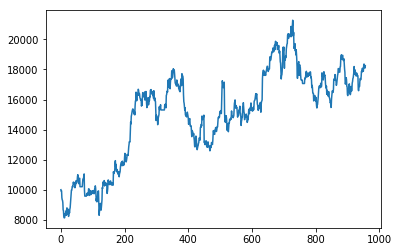

18256.961589813232

In [16]:
#use Decision Tree to predict the label
clf = DecisionTreeClassifier(random_state = 1)
clf = clf.fit(X_train,y_train)
back_tester(X_test,10000,0,clf)
#y_pred = clf.predict(X_test)
#print("Decision Tree accurary:",accuracy_score(y_test, y_pred))